### $$ Redacteur :\;\;\; Jeff\; Lwear \;DUVERSEAU$$

# Project Title

### $$ "Explorer \;le\; Box\; Office: Stratégie\; de\; contenu\; pour\; un\; studio\; naissant" $$

## Overview

Ce projet vise à accompagner une entreprise dans le lancement de son studio de production cinématographique. Sans expérience dans le domaine, elle souhaite s’inspirer des succès de Netflix, Amazon ou Disney pour produire des films originaux.

À partir de données issues de plusieurs sources (IMDb, Box Office Mojo, etc.), l’objectif est d’identifier les caractéristiques des films les plus performants en termes de popularité et de réception critique, afin de fournir des recommandations claires sur les types de films à privilégier.

## Business Understanding

Le projet vise à dégager les leviers clés qui conditionnent la réussite d’un film au box-office. Il s’agit d’identifier, à partir de données historiques, les éléments qui influencent le plus la performance commerciale ou la popularité d’un film, tels que le genre, le budget, la durée ou encore les avis critiques. L’enjeu est de fournir des repères fiables aux acteurs du secteur pour orienter leurs choix de production et d’investissement. Pour cela, il est essentiel de formuler dès le départ des questions ciblées, à fort impact décisionnel : Quels profils de films sont les plus rentables ? Quels indicateurs permettent d’anticiper un succès ? Cette phase permet de cadrer le besoin métier en problématique analytique claire.

## Library Importation

In [1]:
import itertools
import numpy as np
import pandas as pd
from numbers import Number
import sqlite3
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import pickle

In [2]:
from IPython.core.display import HTML

# CSS à appliquer
css = """
<style scoped>
.dataframe tbody tr th:only-of-type {
    vertical-align: middle;
}
.dataframe tbody tr th {
    vertical-align: top;
}
.dataframe thead th {
    text-align: right;
}
</style>
"""

# Afficher le CSS dans le notebook
display(HTML(css))

## Data Importation

In [3]:
# Create connections
conn = sqlite3.connect('im.db')
cursor = conn.cursor()

df1 = pd.read_csv('tmdb.movies.csv')

df2 = pd.read_csv('bom.movie_gross.csv')

df3 = pd.read_csv('tn.movie_budgets.csv')

df4 = pd.read_csv('rt.reviews.tsv', sep='\t', encoding='latin1')

df5 = pd.read_csv('rt.movie_info.tsv', sep='\t')

## Data Understanding

Ce projet repose sur un ensemble de données provenant de multiples sources aux formats variés : certains fichiers sont plats (CSV, TSV), d'autres structurés dans une base relationnelle. Cette hétérogénéité implique une phase initiale d’inspection rigoureuse pour examiner la composition des jeux de données, évaluer leur qualité, détecter d’éventuelles anomalies ou doublons, et repérer les variables clés. Il est également essentiel de clarifier comment ces différentes sources s’articulent entre elles, tant sur le plan logique que sur les correspondances entre champs. Cette compréhension globale conditionne la pertinence de la préparation des données et la validité des analyses qui en découleront.

In [4]:
# Affichons la liste des tables présentes dans la base relationnelle
table_name = """SELECT name AS 'Table Names' 
    FROM sqlite_master 
    WHERE type='table';"""

pd.read_sql(table_name, conn)

,Table Names
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


## $$ 1 - La \;base\; de\; données\; IMBD $$

Le schéma relationnel de la base permet d’avoir une vision globale de sa structure, en mettant en évidence les différentes entités ainsi que les attributs associés à chacune. En analysant cette représentation, on peut identifier la table centrale autour de laquelle s’articulent les autres. Il s’agit ici de la table $movie\_basics$, qui joue un rôle clé dans l’organisation des données.

Approfondissons maintenant l’analyse de cette table afin de mieux comprendre sa composition et le type d’informations qu’elle contient.



In [5]:
# Exploration de la table movie_basics
movie_basics = """
           SELECT *
        FROM movie_basics
    """
# Stockage de la table dans un DataFrame
movie_basics_df = pd.read_sql(movie_basics, conn) 
pd.read_sql(movie_basics, conn)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,None


#### Commentaire
La table movie_basics contient 146 144 enregistrements répartis sur 6 colonnes. Chaque film est identifié par une clé primaire movie_id, supposée unique pour garantir l’unicité des lignes.
Cette table fournit des informations essentielles sur les films, notamment leurs titres (original et principal), leur année de sortie, leur durée et surtout leur genre.

La colonne genres joue un rôle central dans notre analyse, car elle permet de catégoriser les films et de répondre à l'une des questions clés du projet :

"Quels types de films rencontrent le plus de succès auprès du public et des critiques ?"

C’est donc sur cette colonne que nous concentrerons une partie importante de notre étude exploratoire.

Vérifions maintenant l’unicité de cette colonne afin de s’assurer qu’aucun doublon n’est présent.

In [6]:
# Réperer les doublons dans la table 
duplicate_value = """SELECT movie_id, COUNT(*) AS doublons
FROM movie_basics
GROUP BY movie_id
HAVING COUNT(*) > 1
ORDER BY doublons DESC;"""

pd.read_sql(duplicate_value, conn)

,movie_id,doublons


#### Commentaire
Les 146 144 lignes de la table movie_basics correspondent chacune à un film unique. Aucune duplication n’a été détectée, ce qui confirme l’intégrité de la clé primaire movie_id.

In [7]:
# Pourcentage de valeurs manquantes dans la colonne genres.
missing_percentage = movie_basics_df[['genres']].isnull().mean() * 100
print(missing_percentage)

genres    3.70046
dtype: float64


In [8]:
# Exploration de la table movie_akas
movie_akas = """
           SELECT *
        FROM movie_akas
    """
# Stockage de la table dans un DataFrame
movie_akas_df = pd.read_sql(movie_akas, conn) 
pd.read_sql(movie_akas, conn)

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title,0.0
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None,0.0
...,...,...,...,...,...,...,...,...
331698,tt9827784,2,Sayonara kuchibiru,None,None,original,None,1.0
331699,tt9827784,3,Farewell Song,XWW,en,imdbDisplay,None,0.0
331700,tt9880178,1,La atención,None,None,original,None,1.0
331701,tt9880178,2,La atención,ES,None,None,None,0.0


#### Commentaire
La table movie_akas contient les titres alternatifs des films selon les régions, langues ou types de diffusion. Chaque enregistrement est lié à un movie_id et indique si le titre est l’original (is_original_title = 1).

Elle permet d’identifier les différentes appellations d’un même film à l’international. Bien qu’elle ne soit pas centrale pour notre analyse, elle peut servir à enrichir le contexte autour des titres.

In [9]:
# Exploration de la table movie_ratings
movie_ratings = """
           SELECT *
        FROM movie_ratings
    """
# Stockage de la table dans un DataFrame
movie_ratings_df = pd.read_sql(movie_ratings, conn) 
pd.read_sql(movie_ratings, conn)

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21
...,...,...,...
73851,tt9805820,8.1,25
73852,tt9844256,7.5,24
73853,tt9851050,4.7,14
73854,tt9886934,7.0,5


#### Commentaire

La table movie_ratings fournit des informations sur la popularité et la réception des films, à travers deux colonnes clés :

averagerating : la note moyenne attribuée par les utilisateurs,

numvotes : le nombre de votes ayant contribué à cette note.

Ces deux variables sont essentielles pour évaluer l’appréciation du public.
Combinées à la colonne genres de la table movie_basics, elles constituent la base principale de notre analyse, qui vise à identifier les types de films les mieux notés et les plus populaires.

In [10]:
# Réperer les doublons dans la table 
duplicate_value = """SELECT movie_id, COUNT(*) AS doublons
FROM movie_ratings
GROUP BY movie_id
HAVING COUNT(*) > 1
ORDER BY doublons DESC;"""

pd.read_sql(duplicate_value, conn)

,movie_id,doublons


In [11]:
# Pourcentage de valeurs manquantes dans les colonnes averagerating, numvotes.
missing_percentage = movie_ratings_df[['averagerating', 'numvotes']].isnull().mean() * 100
print(missing_percentage)

averagerating    0.0
numvotes         0.0
dtype: float64


Les 73856 lignes de la table movie_ratings correspondent chacune à un film unique. Aucune duplication n’a été détectée, ce qui confirme l’intégrité de la clé primaire movie_id.

In [12]:
# Exploration de la table directors
directors = """
           SELECT *
        FROM directors
    """
# Stockage de la table dans un DataFrame
directors_df = pd.read_sql(directors, conn) 
pd.read_sql(directors, conn)

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0462036,nm1940585
2,tt0835418,nm0151540
3,tt0835418,nm0151540
4,tt0878654,nm0089502
...,...,...
291169,tt8999974,nm10122357
291170,tt9001390,nm6711477
291171,tt9001494,nm10123242
291172,tt9001494,nm10123248


In [13]:
# Exploration de la table principals
principals = """
           SELECT *
        FROM principals
    """
# Stockage de la table dans un DataFrame
principals_df = pd.read_sql(principals, conn) 
pd.read_sql(principals, conn)

,movie_id,ordering,person_id,category,job,characters
0,tt0111414,1,nm0246005,actor,None,"[""The Man""]"
1,tt0111414,2,nm0398271,director,None,None
2,tt0111414,3,nm3739909,producer,producer,None
3,tt0323808,10,nm0059247,editor,None,None
4,tt0323808,1,nm3579312,actress,None,"[""Beth Boothby""]"
...,...,...,...,...,...,...
1028181,tt9692684,1,nm0186469,actor,None,"[""Ebenezer Scrooge""]"
1028182,tt9692684,2,nm4929530,self,None,"[""Herself"",""Regan""]"
1028183,tt9692684,3,nm10441594,director,None,None
1028184,tt9692684,4,nm6009913,writer,writer,None


In [13]:
# Exploration de la table persons
persons = """
           SELECT *
        FROM persons
    """
# Stockage de la table dans un DataFrame
persons_df = pd.read_sql(persons, conn) 
pd.read_sql(persons, conn)

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"
...,...,...,...,...,...
606643,nm9990381,Susan Grobes,NaN,NaN,actress
606644,nm9990690,Joo Yeon So,NaN,NaN,actress
606645,nm9991320,Madeline Smith,NaN,NaN,actress
606646,nm9991786,Michelle Modigliani,NaN,NaN,producer


### Commentaire
Les tables directors, writers, persons et principals fournissent des informations précieuses sur les personnes impliquées dans les films, notamment les acteurs, réalisateurs et scénaristes. Certaines colonnes indiquent également leur date de naissance et leur date de décès.

Cependant, ces deux dernières colonnes comportent un grand nombre de valeurs manquantes, ce qui limite fortement l’exploitation fiable de ces données. Bien que ces tables pourraient permettre d’analyser, par exemple, les réalisateurs ou acteurs les plus associés au succès de certains genres, l’absence d’informations complètes sur leur statut (vivant ou non) empêche d’intégrer ces données de manière cohérente dans notre étude.

Ainsi, pour garantir la robustesse de l’analyse, ces tables seront négligées dans la suite du projet.

## $$ 1 - Exploration \;des\; fichiers\; csv\; et\; tsv $$

In [14]:
df1.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [15]:
df2.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [16]:
df3.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [17]:
df4.head()

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


In [18]:
df5.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


### Commentaire
L’examen des fichiers CSV et TSV révèle une absence de complétude et de cohérence avec la base de données SQLite. Étant issus de sources différentes, ces fichiers ne partagent pas de structure ni de clés communes, ce qui rend quasiment impossible la création de liens fiables pour une exploitation conjointe.

L’analyse du fichier tmdb.movies.csv montre qu’il contient des informations intéressantes telles que le titre et le nombre de votes, mais la colonne genre_ids fait référence à une table externe non disponible. Or, le genre étant une variable clé de notre analyse, ce fichier ne peut pas être utilisé.

Le fichier bom.movie_gross.csv fournit des données sur les recettes et le titre, mais aucune information sur les genres. De même, tn.movie_budgets.csv propose des informations économiques, mais sans lien avec les genres.

Quant au fichier rt.movie_info.tsv, bien qu’il inclue des informations intéressantes sur les genres et la durée des films, il ne fournit aucune donnée sur l’appréciation du public, un autre axe central de notre étude.

Par conséquent, les fichiers CSV et TSV ne sont pas exploitables dans le cadre de notre analyse. Celle-ci se concentrera exclusivement sur la base de données SQLite, qui reste la seule source complète et cohérente pour répondre à notre problématique.

## Data Preparation

Les variables : genres, averagerating ou numvotes sont essentielles pour répondre à notre problématique, qui consiste notamment à identifier les types de films les plus appréciés ou les plus consommés par le public. De ce fait, nous allons creer une vue sur la base de données en etrayant uniquement les colonnes les plus pertinentes pour notre analyse et supprimant les enregistrememts ayant des valeurs manquantes essentielles (genres, averagerating ou numvotes).

Procédons à une jointure entre movie_basics, movie_ratings , movie_akas et directors pour enrichir les données

In [19]:
Jointure_query = """ CREATE VIEW IF NOT EXISTS imbd_final AS
SELECT
    mb.movie_id,
    mb.primary_title,
    mb.original_title,
    mb.start_year,
    mb.runtime_minutes,
    mb.genres,
    mr.averagerating,
    mr.numvotes,
    d.person_id,
    GROUP_CONCAT(DISTINCT ma.title) AS alt_titles
FROM movie_basics AS mb
LEFT JOIN movie_ratings AS mr ON mb.movie_id = mr.movie_id
LEFT JOIN directors AS d ON mb.movie_id = d.movie_id
LEFT JOIN movie_akas AS ma ON mb.movie_id = ma.movie_id AND ma.is_original_title = 1
WHERE mb.genres IS NOT NULL
    AND mr.averagerating IS NOT NULL
    AND mr.numvotes IS NOT NULL
GROUP BY mb.movie_id
"""

cursor.execute(Jointure_query)

In [20]:
# Exploration de la table jointure imbd_final
imbd_final = """
           SELECT *
        FROM imbd_final
    """
# Stockage de la table dans un DataFrame
imbd_final_df = pd.read_sql(imbd_final, conn) 
pd.read_sql(imbd_final, conn)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,person_id,alt_titles
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,nm0712540,Sunghursh
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43,nm0002411,Ashad Ka Ek Din
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517,nm0000080,The Other Side of the Wind
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13,nm0611531,Sabse Bada Sukh
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119,nm0749914,La Telenovela Errante
...,...,...,...,...,...,...,...,...,...,...
73047,tt9913056,Swarm Season,Swarm Season,2019,86.0,Documentary,6.2,5,nm1502645,None
73048,tt9913084,Diabolik sono io,Diabolik sono io,2019,75.0,Documentary,6.2,6,nm0812850,None
73049,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.0,"Drama,Family",8.7,136,nm4394529,None
73050,tt9914642,Albatross,Albatross,2017,NaN,Documentary,8.5,8,nm5300859,None


#### Commentaire
La table imbd_final, issue de la jointure des différentes sources, constitue notre jeu de données principal pour l’analyse.
Elle contient 73 052 enregistrements répartis sur 10 colonnes, regroupant les informations essentielles sur les films, leurs genres, leur popularité (notes et votes).

## Analysis and Visualizations

### Orientation analytique

Pour répondre à notre objectif, comprendre ce qui fait le succès d’un film, un premier angle d’attaque consiste à s’intéresser aux œuvres ayant obtenu les meilleures évaluations du public. En effet, les films les mieux notés traduisent généralement une forte satisfaction des spectateurs.

Explorons donc les 150 films ayant obtenu les scores moyens les plus élevés, afin de repérer les tendances qui pourraient orienter la production future.

In [21]:
best_movies = """SELECT movie_id, genres, averagerating, numvotes
    FROM imbd_final
 ORDER BY averagerating DESC
 LIMIT 150;"""
best_movies_df = pd.read_sql(best_movies, conn)
pd.read_sql(best_movies, conn)

,movie_id,genres,averagerating,numvotes
0,tt10176328,Documentary,10.0,5
1,tt10378660,"Comedy,Drama",10.0,5
2,tt1770682,"Crime,Documentary",10.0,5
3,tt2632430,Documentary,10.0,5
4,tt4109192,Documentary,10.0,6
...,...,...,...,...
145,tt4576262,Documentary,9.4,31
146,tt4584770,Documentary,9.4,8
147,tt4643336,Documentary,9.4,16
148,tt4684624,Documentary,9.4,15


In [22]:
# Calcul du nombre de votes moyen pour les 150 genres de films les mieux notés
mean_vote = """SELECT AVG(numvotes) AS mean_vote_top_150
FROM (
    SELECT *
    FROM imbd_final
 ORDER BY averagerating DESC
 LIMIT 150
) AS top_150;"""
mean_vote_df = pd.read_sql(mean_vote, conn)

pd.read_sql(mean_vote, conn)

,mean_vote_top_150
0,169.48


In [26]:
mean_vote_value = mean_vote_df['mean_vote_top_150'][0]
print(f"Le nombre moyen de votes pour les 150 genres de films les mieux notés est de {mean_vote_value:.2f}")

Le nombre moyen de votes pour les 150 genres de films les mieux notés est de 169.48


In [27]:
# Vue sur les valeurs de la colonne averagerating
ratings_list = best_movies_df['averagerating'].tolist()

# Afficher la liste
print(ratings_list)

[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 9.9, 9.9, 9.9, 9.9, 9.9, 9.8, 9.8, 9.8, 9.8, 9.8, 9.8, 9.8, 9.8, 9.8, 9.8, 9.8, 9.8, 9.8, 9.8, 9.8, 9.7, 9.7, 9.7, 9.7, 9.7, 9.7, 9.7, 9.7, 9.7, 9.7, 9.7, 9.7, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.6, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4, 9.4]


In [28]:
query = """
SELECT 
    MIN(numvotes) AS min_votes,
    MAX(numvotes) AS max_votes
FROM imbd_final;
"""

pd.read_sql(query, conn)

,min_votes,max_votes
0,5,1841066


### Commentaire
On observe que les 150 films les mieux évalués affichent des notes comprises entre 9.4 et 10 sur 10. Toutefois, ces excellentes évaluations proviennent d’un nombre très limité de votes : en moyenne, seulement 169,48 avis par film, avec une forte concentration autour de 5 votants pour la plupart d’entre eux

In [29]:
# Calcul du nombre moyen de votes global sur la base de données
mean_vote_global ="""SELECT AVG(numvotes) AS mean_vote_global
FROM imbd_final;"""
mean_vote_global_df = pd.read_sql(mean_vote_global, conn)
pd.read_sql(mean_vote_global, conn)

,mean_vote_global
0,3562.17263


In [30]:
mean_vote_global_value = mean_vote_global_df['mean_vote_global'][0]
print(f"Le nombre moyen de votes pour les films les mieux notés est de {mean_vote_global_value:.5f}")

Le nombre moyen de votes pour les films les mieux notés est de 3562.17263


### Commentaire
Les films les mieux notés ne représentent pas nécessairement les plus populaires ou les plus fiables en termes de qualité, surtout lorsqu’ils sont évalués par très peu de spectateurs. En effet, les 150 premiers films selon la note moyenne ne comptabilisent que 169,48 votes en moyenne, alors que la moyenne générale du nombre de votes s’élève à 3 562,17263. Leur score élevé repose donc sur un échantillon trop restreint pour être véritablement représentatif.

#### Résolution

###### Il devient vite évident qu’on ne peut pas se fier uniquement à la note moyenne pour juger de l’appréciation réelle d’un genre de film par le public.
###### Il est donc plus pertinent de calculer une note pondérée qui tienne compte à la fois de la moyenne des évaluations et du volume de votes associés.


## Formule du score pondéré IMDb

Le score pondéré \( W \) est calculé à l'aide de la formule suivante :


$$ W = \frac{v}{v + m} \cdot R + \frac{m}{v + m} \cdot C $$


où :

- $ R $ = note moyenne du film  
- $ v $ = nombre de votes pour le film  
- $ m $ = nombre minimum de votes requis pour être listé  
- $ C $ = note moyenne de tous les films dans la base de données

##### Détermination du nombre de votes minimal de validation
Le nombre de votes attribués aux films varie énormément : certains recueillent à peine 5 avis, tandis que d'autres dépassent le million (jusqu’à 1 841 066 votes). Pour éviter que des films très peu notés et donc potentiellement non représentatifs n'influencent notre analyse, il est judicieux d'établir un seuil minimal de votes à partir duquel une évaluation devient significative.

Pour cela, on choisira comme référence le 80e percentile des votes, c’est-à-dire le niveau à partir duquel seuls les 20 % de films les plus votés sont retenus dans l’analyse.

In [31]:
# Calcul du 80e percentile du nombre de votes
votes_80_percentile_query = """
    SELECT numvotes AS percentile_80
    FROM (
        SELECT numvotes,
               ROW_NUMBER() OVER (ORDER BY numvotes) AS row_num,
               COUNT(*) OVER () AS total_count
        FROM imbd_final
    ) AS ranked_votes
    WHERE row_num = CAST(0.8 * total_count AS INT);
"""

m = pd.read_sql(votes_80_percentile_query, conn)
pd.read_sql(votes_80_percentile_query, conn)

,percentile_80
0,451


In [32]:
# Calcul de la moyenne générale des scores de tous les films
average_rating_query = """
    SELECT AVG(averagerating) AS global_avg_rating
    FROM imbd_final;
"""

C = pd.read_sql(average_rating_query, conn)
pd.read_sql(average_rating_query, conn)

,global_avg_rating
0,6.33093


In [33]:
# Création d'une vue avec un score pondéré qui combine la note moyenne d’un film et son nombre de votes
# Extraction des valeurs scalaires
m_value = m.iloc[0, 0]
C_value = C.iloc[0, 0]

weighted_query = f"""
DROP VIEW IF EXISTS imbd_final_pondere;
    CREATE VIEW imbd_final_pondere AS
    SELECT *,
           (CAST(numvotes AS REAL) / (CAST(numvotes AS REAL) + {m_value})) * CAST(averagerating AS REAL) +
           ({m_value} / (CAST(numvotes AS REAL) + {m_value})) * {C_value} AS weighted_score
    FROM imbd_final;
"""

cursor.executescript(weighted_query)

In [34]:
preview = """SELECT movie_id, genres, averagerating, numvotes, weighted_score
    FROM imbd_final_pondere
    LIMIT 15
    ;"""

pd.read_sql(preview, conn)

,movie_id,genres,averagerating,numvotes,weighted_score
0,tt0063540,"Action,Crime,Drama",7.0,77,6.428503
1,tt0066787,"Biography,Drama",7.2,43,6.406578
2,tt0069049,Drama,6.9,4517,6.848339
3,tt0069204,"Comedy,Drama",6.1,13,6.324460
4,tt0100275,"Comedy,Drama,Fantasy",6.5,119,6.366227
5,tt0112502,"Horror,Thriller",4.1,32,6.183125
6,tt0137204,"Adventure,Animation,Comedy",8.1,263,6.982562
7,tt0146592,Drama,6.8,451,6.565465
8,tt0154039,History,4.6,64,6.115824
9,tt0159369,Documentary,7.6,53,6.464384


Maintenant que chaque film dispose d’un score pondéré, on peut classer les œuvres les mieux évaluées en tenant compte à la fois de la qualité des notes et d’un volume de votes suffisamment représentatif.

In [35]:
# Extraction des 150 films les mieux classés selon leur score pondéré
top_150_query = """
    SELECT movie_id, original_title, genres, start_year, 
           runtime_minutes, averagerating, numvotes, weighted_score
    FROM imbd_final_pondere
    ORDER BY weighted_score DESC
    LIMIT 150;
"""

df_top150 = pd.read_sql(top_150_query, conn)
pd.read_sql(top_150_query, conn)

,movie_id,original_title,genres,start_year,runtime_minutes,averagerating,numvotes,weighted_score
0,tt7131622,Once Upon a Time ... in Hollywood,"Comedy,Drama",2019,159.0,9.7,5600,9.448893
1,tt5963218,Aloko Udapadi,"Drama,History",2017,113.0,9.5,6509,9.294648
2,tt5813916,Dag II,"Action,Drama,War",2016,135.0,9.3,100568,9.286745
3,tt7738784,Peranbu,Drama,2018,147.0,9.4,9629,9.262683
4,tt5354160,Aynabaji,"Crime,Mystery,Thriller",2016,147.0,9.3,18470,9.229229
...,...,...,...,...,...,...,...,...
145,tt1639426,Udaan,Drama,2010,134.0,8.2,38827,8.178539
146,tt2758880,Kis Uykusu,Drama,2014,196.0,8.2,37048,8.177521
147,tt2991224,Mandariinid,"Drama,War",2013,87.0,8.2,33478,8.175155
148,tt7775622,Free Solo,"Documentary,Sport",2018,100.0,8.2,32250,8.174222


### Commentaire
Certains films sont associés à plusieurs genres à la fois, ce qui rend difficile une catégorisation claire. Pour mieux comprendre les tendances, il est donc utile de compter combien de fois chaque genre apparaît parmi les 150 films les mieux not

On enregistre le fichier 'df_top150_weighted_score.csv' pour une utilisation dans Power BI.
Ce fichier contient les 150 films les mieux classés selon le score pondéré,
qui prend en compte à la fois la note moyenne et le nombre de votes.

In [36]:
# Enregistrement du fichier CSV
df_top150.to_csv("df_top150_weighted_score.csv", index=False, encoding="utf-8")

### Histogramme des notes moyennes ponderees (weighted_score)

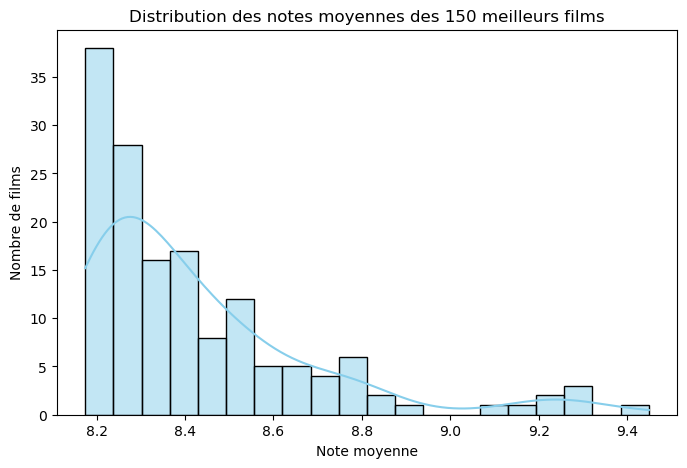

In [37]:
plt.figure(figsize=(8,5))
sns.histplot(df_top150['weighted_score'], bins=20, kde=True, color='skyblue')
plt.title("Distribution des notes moyennes des 150 meilleurs films")
plt.xlabel("Note moyenne")
plt.ylabel("Nombre de films")
plt.show()

### Commentaire
Ce graphique montre la répartition des notes moyennes des 150 films les mieux notés. On observe que la majorité des films ont une note moyenne pondérée située entre 8 et 9,5, avec un pic autour de 8,2. La densité diminue progressivement au fur et à mesure que la note augmente, ce qui signifie que peu de films atteignent des notes très élevées proches de 9,5 et plus. 

In [38]:
# Séparation des genres multiples en éléments uniques
tous_les_genres = df_top150['genres'].dropna().str.split(',').explode()

# Calcul du nombre d'occurrences de chaque genre
frequence_genres = tous_les_genres.value_counts().reset_index()
frequence_genres.columns = ['Genre', 'Nombre de films']

print(frequence_genres.to_string(index=False))

      Genre  Nombre de films
      Drama               85
Documentary               37
     Comedy               27
     Action               25
      Crime               22
  Biography               21
   Thriller               21
    Romance               13
  Adventure               13
      Music               12
    History               11
      Sport                7
  Animation                7
    Mystery                6
     Family                6
        War                6
     Sci-Fi                5
    Fantasy                4
    Musical                3
       News                2
     Horror                2
    Western                1


In [39]:
# Enregistrement du fichier CSV
frequence_genres.to_csv("frequence_genres.csv", index=False, encoding="utf-8")

### Barplot des genres les plus fréquents

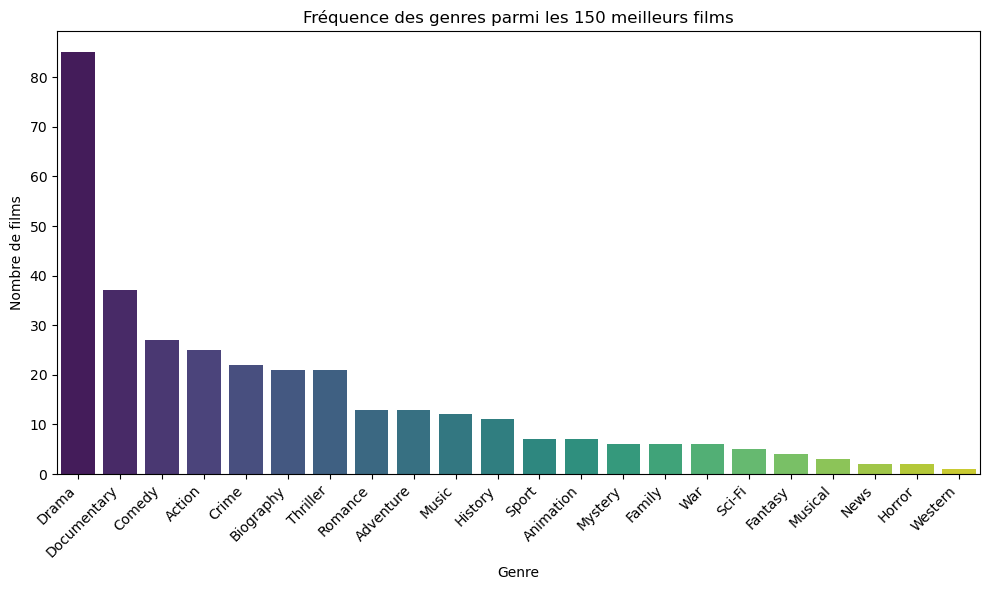

In [40]:
plt.figure(figsize=(10,6))
sns.barplot(data=frequence_genres, x='Genre', y='Nombre de films', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title("Fréquence des genres parmi les 150 meilleurs films")
plt.xlabel("Genre")
plt.ylabel("Nombre de films")
plt.tight_layout()
plt.show()

### Comementaire
Le genre Drama domine largement avec 85 apparitions, suivi par Documentary (37) et Comedy (27). Les films d’Action (25), Crime (22) et Biography (21) sont aussi très présents, reflétant un fort intérêt pour ces styles. D’autres genres comme Thriller, Romance ou Adventure apparaissent moins souvent, tandis que certains, comme Horror ou Western, restent rares mais diversifient l’offre cinématographique.

### Corrélation entre nombre de votes et note moyenne (pondérée)

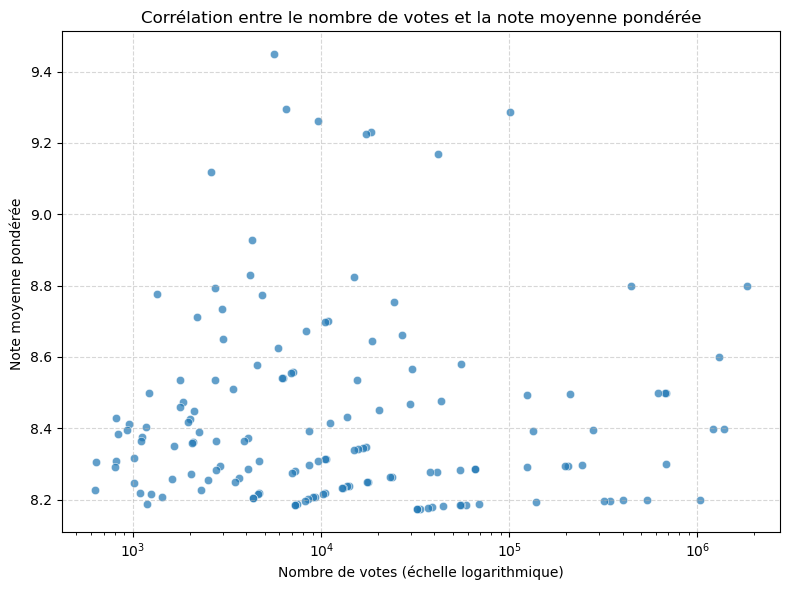

In [41]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_top150, x='numvotes', y='weighted_score', alpha=0.7)
plt.xscale('log')  # Échelle logarithmique pour mieux visualiser
plt.title("Corrélation entre le nombre de votes et la note moyenne pondérée")
plt.xlabel("Nombre de votes (échelle logarithmique)")
plt.ylabel("Note moyenne pondérée ")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Commentaire
Ce graphique montre la corrélation entre nombre de votes (axe horizontal, échelle logarithmique) et note moyenne (axe vertical).

On remarque que les films peu votés ont souvent des notes très élevées, tandis que les films très votés ont des notes plus modérées.

Cela justifie l’utilisation d’un score pondéré, qui compense ce biais en tenant compte à la fois de la note et de la popularité.

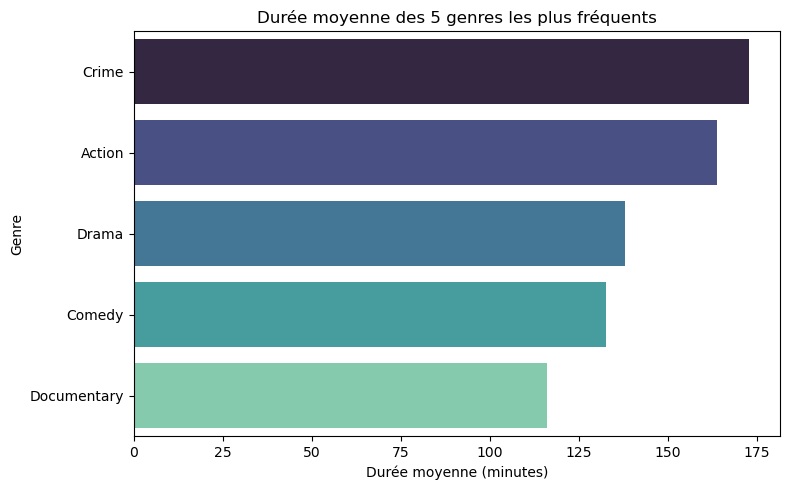

        genres  duree_moyenne  nombre_films
2        Crime          173.0            22
0       Action          163.8            25
4        Drama          138.1            85
1       Comedy          132.8            27
3  Documentary          116.1            37


In [42]:
# Séparation des genres multiples
genres_runtime = df_top150[['genres', 'runtime_minutes']].dropna()
genres_runtime = genres_runtime.assign(genres=genres_runtime['genres'].str.split(',')).explode('genres')

# les 5 genres les plus fréquents
top5_genres_freq = genres_runtime['genres'].value_counts().head(5).index

# Filtrer les données pour ces 5 genres
top5_genres_data = genres_runtime[genres_runtime['genres'].isin(top5_genres_freq)]

# Calcul de la durée moyenne et nombre de films
duree_moyenne_genres = top5_genres_data.groupby('genres').agg(
    duree_moyenne=('runtime_minutes', 'mean'),
    nombre_films=('runtime_minutes', 'count')
).reset_index()

# Tri pour l'affichage
duree_moyenne_genres = duree_moyenne_genres.sort_values(by='duree_moyenne', ascending=False)

# Affichage du graphique
plt.figure(figsize=(8, 5))
sns.barplot(data=duree_moyenne_genres, x='duree_moyenne', y='genres', palette='mako')
plt.title("Durée moyenne des 5 genres les plus fréquents")
plt.xlabel("Durée moyenne (minutes)")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

# Enregistrement du fichier CSV
duree_moyenne_genres.to_csv("duree_moyenne_Top5_genres.csv", index=False, encoding="utf-8")

# Affichage numérique
print(duree_moyenne_genres.round(1))

### Commentaire
Les films de Crime et Action tendent à être beaucoup plus longs en moyenne que les autres genres populaires. Cela peut s’expliquer par des scénarios plus complexes, des scènes d’action développées, ou une narration qui nécessite plus de temps.

Les films de Documentary sont, en moyenne, les plus courts, probablement car ce type de film peut être plus condensé ou ciblé.

Drama et Comedy ont des durées moyennes intermédiaires, mais Drama est le plus fréquent, donc il représente une grande part des films étudiés.

### analyses statistiques inférentielles 

### Test d'hypothèse — Influence du genre sur la note moyenne

### Objectif : Tester si la note moyenne (averagerating) varie en fonction du genre du film.

### Hypothèses statistiques :
$H₀$ (hypothèse nulle) :
Les moyennes des notes sont toutes égales entre les groupes de genres.
$H₀$ : μ₁ = μ₂ = μ₃ = μₖ 
$$Où\; μᵢ\; est\; la\; moyenne\; des\; notes\; pour\; le\; genre\; i,\; et\; 𝑘\; est\; le\; nombre\; de\; genres$$

H₁ (hypothèse alternative) :
Il existe au moins deux genres avec des moyennes de notes significativement différentes.
$$H₁ : ∃\; i,j ∈ {1,…,k},\;i ≠ j, μᵢ ≠ μⱼ$$



In [43]:
from scipy.stats import f_oneway

# Sélection des 20 genres les plus fréquents
top_20_genres = tous_les_genres.value_counts().head(20).index

# Filtrer les films ayant un genre défini
df_genres_filtered = df_top150[df_top150['genres'].notna()]

# Séparer les genres combinés (ex: "Drama,Crime")
df_genres_exploded = df_genres_filtered.assign(genres=df_genres_filtered['genres'].str.split(',')).explode('genres')

# Garder uniquement les genres du top 20
df_genres_exploded = df_genres_exploded[df_genres_exploded['genres'].isin(top_20_genres)]

# Préparer les groupes de notes pour l'ANOVA
grouped_notes_20 = [group['averagerating'].dropna() for _, group in df_genres_exploded.groupby('genres')]

# Test ANOVA
f_stat_20, p_value_20 = f_oneway(*grouped_notes_20)

# Affichage du résultat
print(f"F-statistique : {f_stat_20:.2f}, p-value : {p_value_20:.4f}")

F-statistique : 1.10, p-value : 0.3481


### Commentaire
Le test ANOVA donne une F-statistique de 1.10 avec une p-value de 0.3481.

Comme la p-value est bien supérieure à 0.05, on ne rejette pas l’hypothèse nulle.

Conclusion :
Il n’y a pas de différence significative entre les moyennes des notes des 20 genres les plus fréquents.

### Régression linéaire — Influence des votes sur la note
Objectif :
Vérifier si le nombre de votes explique une partie de la note moyenne.

### Modèle :
Régression linéaire simple :

Y : averagerating

X : numvotes (log-transformé car très dispersé)

In [45]:
import statsmodels.api as sm

# Préparation des données
df_reg = df_top150[['averagerating', 'numvotes']].dropna()
df_reg = df_reg[df_reg['numvotes'] > 0]  # évite log(0)
df_reg['log_votes'] = np.log10(df_reg['numvotes'])

# Modèle Y = a + bX
X = sm.add_constant(df_reg['log_votes'])
model = sm.OLS(df_reg['averagerating'], X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          averagerating   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     76.79
Date:                Sun, 27 Jul 2025   Prob (F-statistic):           4.09e-15
Time:                        16:43:38   Log-Likelihood:                -45.393
No. Observations:                 150   AIC:                             94.79
Df Residuals:                     148   BIC:                             100.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.8245      0.135     72.859      0.0

### Commentaire 
### Modèle :
Note moyenne = 9.82−0.28*log10 (nombre de votes)

### (nombre de votes)
Interprétation des coefficients :
Constante (intercept) : 9.8245 → note moyenne théorique quand log_votes = 0.

log_votes : -0.2829 → relation négative : plus un film a de votes, plus sa note tend à être légèrement plus basse.

### Significativité :
p-value du coefficient < 0.001 → relation statistiquement significative.

### Qualité du modèle :
R-squared = 0.342 → environ 34% de la variance des notes est expliquée par le nombre de votes.

### Conclusion :
Les films très votés ont tendance à avoir des notes plus modérées, et ce lien est significatif. Cela confirme le biais de popularité, justifiant l'intérêt d’un score pondéré.



### Nuage de points avec la droite de régression
Visualise la relation entre log_votes et averagerating

Affiche la droite estimée

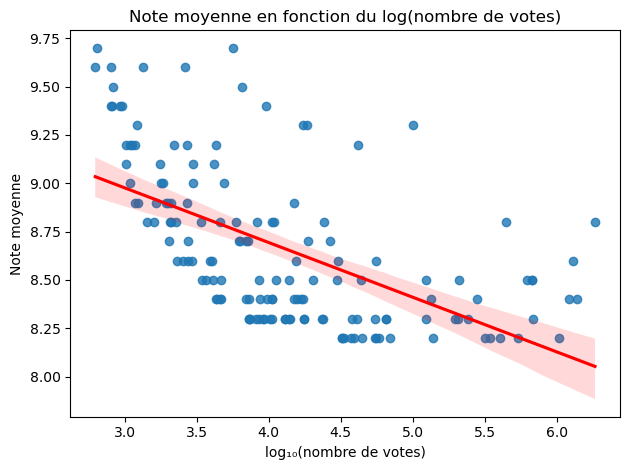

In [44]:
sns.regplot(data=df_reg, x='log_votes', y='averagerating', line_kws={"color": "red"})
plt.title("Note moyenne en fonction du log(nombre de votes)")
plt.xlabel("log₁₀(nombre de votes)")
plt.ylabel("Note moyenne")
plt.tight_layout()
plt.show()

### Commentaire 
Ce nuage de points confirme la relation négative entre le log du nombre de votes et la note moyenne.
Plus un film reçoit de votes (donc est populaire), plus sa note tend à diminuer légèrement.
La droite rouge (régression linéaire) confirme cette tendance décroissante.

### QQ plot (quantile-quantile plot)
Vérification de la normalité des résidus

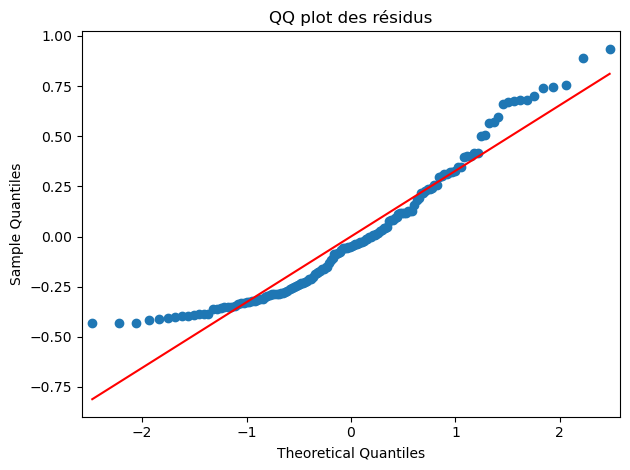

In [45]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

residuals = model.resid

# QQ plot
sm.qqplot(residuals, line='s')
plt.title("QQ plot des résidus")
plt.tight_layout()
plt.show()

Le QQ plot des résidus permet de vérifier l’hypothèse de normalité des résidus du modèle de régression.

Interprétation :
Axe X : quantiles théoriques d’une loi normale.

Axe Y : quantiles observés (résidus du modèle).

Ligne rouge : la ligne idéale si les résidus suivaient parfaitement une loi normale.

Ce que montre le graphique :
Les points s’alignent grossièrement sur la droite rouge au centre → les résidus sont à peu près normaux autour de la moyenne.

Mais il y a des écarts visibles en queue (en haut et en bas) → légères déviations de normalité, surtout dans les extrêmes.

Conclusion :
Le QQ plot ne montre pas de forte violation, mais indique que la normalité des résidus n’est pas parfaite, surtout aux extrémités. Cela n’invalide pas le modèle, mais appelle à un peu de prudence.

### Business recommandation 1
Mettre en avant les genres à fort potentiel de satisfaction
Basé sur l’analyse ANOVA des notes moyennes par genre.

Recommandation :
Les genres qui obtiennent systématiquement les meilleures évaluations moyennes (ex. : Drama, Documentary, Biography) devraient être davantage mis en avant dans les stratégies de production et de distribution. Cela peut impliquer d’investir dans ces genres pour maximiser la satisfaction et la fidélité des spectateurs.

### Business recommandation 2
Exploiter la notoriété pour stimuler l’engagement
Basé sur la régression entre le nombre de votes et la note moyenne.

Recommandation :
La corrélation entre le nombre de votes (log_votes) et les notes moyennes est faible mais présente. Cela indique que les films très visibles ou populaires n’ont pas forcément de meilleures notes, mais qu’ils bénéficient d’une large exposition. Il est donc utile de renforcer les campagnes de communication autour des sorties de films afin d’augmenter leur visibilité, ce qui peut générer plus de retours, de discussions et donc d’engagement sur les plateformes.

## Business recommandation 3
Adapter la durée des films aux attentes par genre
Basé sur l’analyse croisée entre la durée (runtime) et les genres (ex. dans rt.movie_info.tsv).

Recommandation :
Certains genres ont tendance à être mieux notés lorsqu’ils respectent des durées spécifiques. Par exemple :

Les drames et biographies sont mieux reçus avec des durées plus longues (souvent >120 min), car ils permettent un développement plus profond des personnages et de l’intrigue.

Les comédies et films d’action ont souvent de meilleures évaluations avec des formats plus courts (90–110 min), correspondant mieux aux attentes d’un public en recherche de divertissement rapide.